<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/ImageGPT/(Un)conditional_image_generation_with_ImageGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting-up environment

In [1]:
!rm -r transformers
!git clone -b add_image_gpt https://github.com/nielsrogge/transformers.git
!cd transformers
!pip install -q ./transformers

Cloning into 'transformers'...
remote: Enumerating objects: 92472, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 92472 (delta 5), reused 10 (delta 5), pack-reused 92456
Receiving objects: 100% (92472/92472), 70.51 MiB | 20.83 MiB/s, done.
Resolving deltas: 100% (66575/66575), done.
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [2]:
!git clone https://github.com/openai/image-gpt.git
!python image-gpt/download.py --clusters --download_dir content/clusters

fatal: destination path 'image-gpt' already exists and is not an empty directory.
input args:
 {
    "download_dir":"content/clusters",
    "bert":false,
    "model":null,
    "ckpt":null,
    "clusters":true,
    "dataset":null
}
Fetching kmeans_centers.npy: 7.00kit [00:00, 4.98Mit/s]                         


## Unconditional image generation

First, we initialize the feature extractor and model, and put the model on the GPU.

In [3]:
from transformers import ImageGPTFeatureExtractor, ImageGPTForCausalLM
import numpy as np
import torch

feature_extractor = ImageGPTFeatureExtractor.from_pretrained('openai/imagegpt-medium')
model = ImageGPTForCausalLM.from_pretrained('openai/imagegpt-medium')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

ImageGPTForCausalLM(
  (transformer): ImageGPTModel(
    (wte): Embedding(513, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): ImageGPTBlock(
        (ln_1): ImageGPTLayerNorm()
        (attn): ImageGPTAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): ImageGPTLayerNorm()
        (mlp): ImageGPTMLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): ImageGPTBlock(
        (ln_1): ImageGPTLayerNorm()
        (attn): ImageGPTAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): ImageGPTLayerNorm()
        (mlp): ImageGPTMLP(
          

Here we only feed the start of sequence (SOS) special token to the model, and let it generate 32x32 = 1024 pixel values using the `generate()` method. Each pixel value is one of 512 possible color clusters.

In [4]:
# unconditional generation of 8 images
batch_size = 8
context = torch.full((batch_size, 1), model.config.vocab_size - 1) #initialize with SOS token (with ID 512)
context = torch.tensor(context).to(device)
output = model.generate(input_ids=context, max_length=model.config.n_positions + 1, temperature=1.0, do_sample=True, top_k=40)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


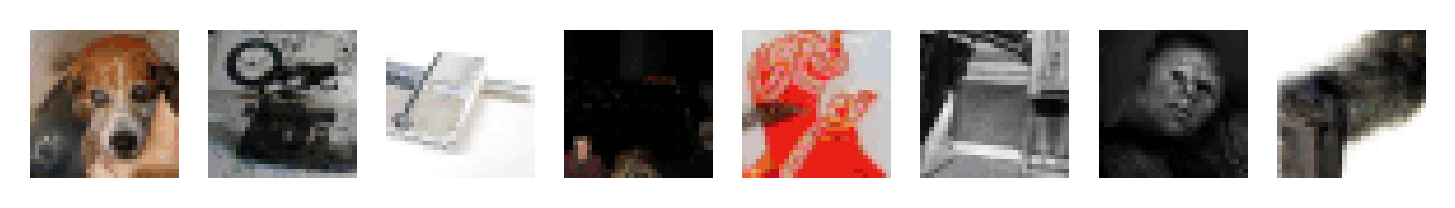

In [5]:
#visualize samples with Image-GPT color palette.
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

clusters = feature_extractor.clusters
n_px = feature_extractor.size

samples = output[:,1:].cpu().detach().numpy()
samples_img = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [32, 32, 3]).astype(np.uint8) for s in samples] # convert color cluster tokens back to pixels
f, axes = plt.subplots(1, batch_size, dpi=300)

for img, ax in zip(samples_img, axes):
    ax.axis('off')
    ax.imshow(img)

# Tokenize Cropped Images for Image Completion

Given an image, we first create a tensor of shape (batch_size, 32, 32, 3). It contains `batch_size` times our image, resized to a resolution of 32x32.

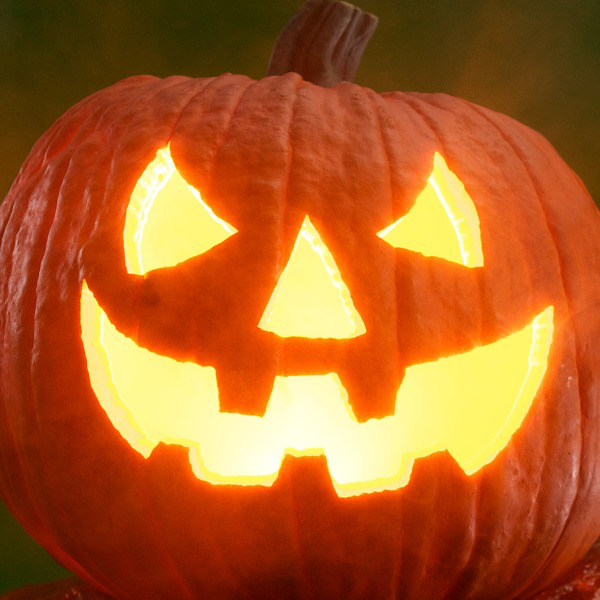

In [6]:
import requests
from PIL import Image

url = 'https://assetsnffrgf-a.akamaihd.net/assets/m/502013285/univ/art/502013285_univ_sqr_xl.jpg'
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
image

In [7]:
encoding = feature_extractor([image for _ in range(8)], return_tensors="pt")
print(encoding.keys())

dict_keys(['pixel_values'])


In [8]:
encoding.pixel_values[0,:3]

tensor([451, 451, 451])

In [9]:
encoding.pixel_values.shape

torch.Size([8, 1024])

In [10]:
samples = encoding.pixel_values.numpy()
n_px_crop = 16
primers = samples.reshape(-1,n_px*n_px)[:,:n_px_crop*n_px] # crop top n_px_crop rows. These will be the conditioning tokens

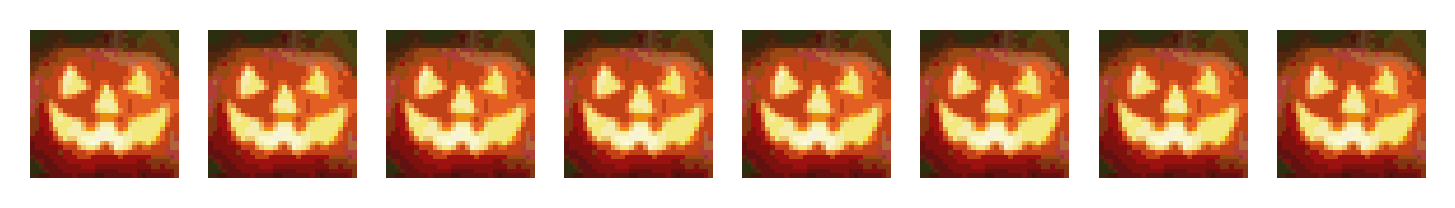

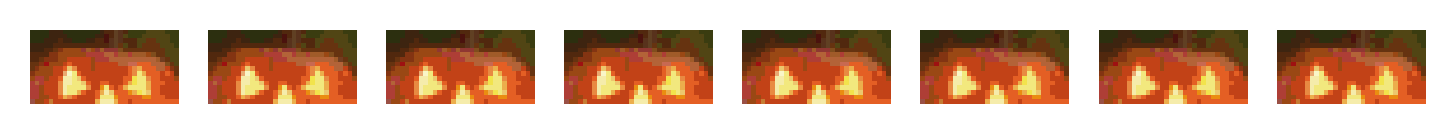

In [11]:
#visualize samples and crops with Image-GPT color palette. Should look similar to original resized images
samples_img = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [n_px, n_px, 3]).astype(np.uint8) for s in samples] # convert color clusters back to pixels
primers_img = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [n_px_crop,n_px, 3]).astype(np.uint8) for s in primers] # convert color clusters back to pixels

f, axes = plt.subplots(1, batch_size, dpi=300)
for img,ax in zip(samples_img, axes):
    ax.axis('off')
    ax.imshow(img)

f, axes2 = plt.subplots(1, batch_size, dpi=300)
for img,ax in zip(primers_img, axes2):
    ax.axis('off')
    ax.imshow(img)

We can verify the shape of the samples and primers:

In [12]:
samples.shape

(8, 1024)

In [13]:
primers.shape

(8, 512)

# Conditional Image Completion

In [14]:
context = np.concatenate((np.full((batch_size, 1), model.config.vocab_size - 1), primers), axis=1)
context = torch.tensor(context).to(device)
output = model.generate(input_ids=context, max_length=n_px*n_px + 1, temperature=1.0, do_sample=True, top_k=40)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


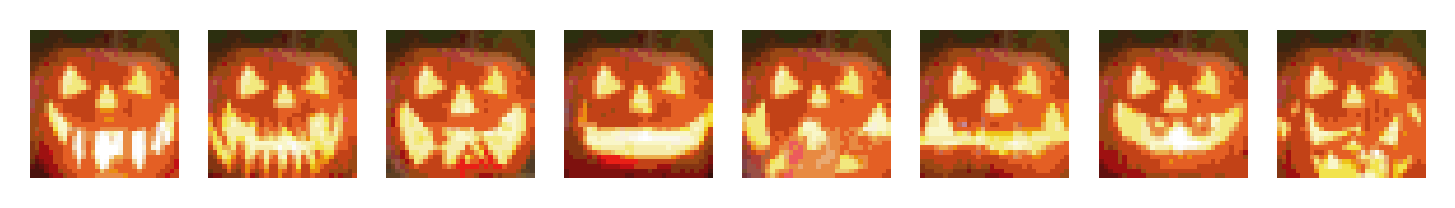

In [15]:
#visualize samples with Image-GPT color palette. 
samples = output[:,1:].cpu().detach().numpy()
samples_img = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [n_px, n_px, 3]).astype(np.uint8) for s in samples] # convert color cluster tokens back to pixels
f, axes = plt.subplots(1, batch_size, dpi=300)

for img,ax in zip(samples_img, axes):
    ax.axis('off')
    ax.imshow(img)

## Verifying code examples

Here we verify whether the code examples in the docs of ImageGPT work fine.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


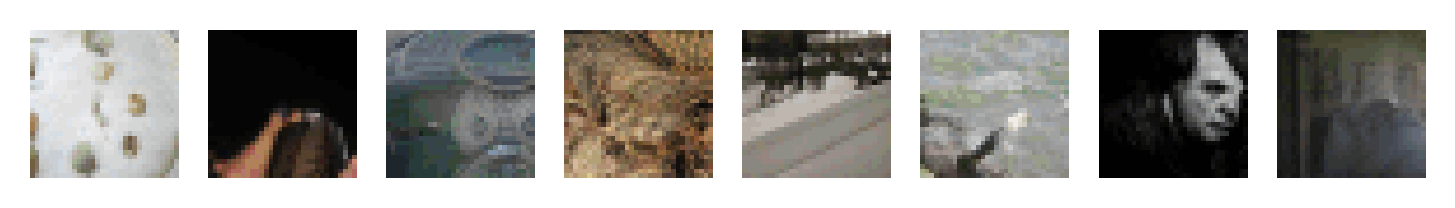

In [16]:
from transformers import ImageGPTFeatureExtractor, ImageGPTForCausalLM
import torch
import matplotlib.pyplot as plt
import numpy as np

feature_extractor = ImageGPTFeatureExtractor.from_pretrained('openai/imagegpt-small')
model = ImageGPTForCausalLM.from_pretrained('openai/imagegpt-small')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# unconditional generation of 8 images
batch_size = 8
context = torch.full((batch_size, 1), model.config.vocab_size - 1) #initialize with SOS token
context = torch.tensor(context).to(device)
output = model.generate(input_ids=context, max_length=model.config.n_positions + 1, temperature=1.0, do_sample=True, top_k=40)

clusters = feature_extractor.clusters
n_px = feature_extractor.size

samples = output[:,1:].cpu().detach().numpy()
samples_img = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [n_px, n_px, 3]).astype(np.uint8) for s in samples] # convert color cluster tokens back to pixels
f, axes = plt.subplots(1, batch_size, dpi=300)

for img, ax in zip(samples_img, axes):
   ax.axis('off')
   ax.imshow(img)

In [17]:
from transformers import ImageGPTFeatureExtractor, ImageGPTForImageClassification
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

feature_extractor = ImageGPTFeatureExtractor.from_pretrained('openai/imagegpt-small')
model = ImageGPTForImageClassification.from_pretrained('openai/imagegpt-small')

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Some weights of the model checkpoint at openai/imagegpt-small were not used when initializing ImageGPTForImageClassification: ['lm_head.weight']
- This IS expected if you are initializing ImageGPTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ImageGPTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ImageGPTForImageClassification were not initialized from the model checkpoint at openai/imagegpt-small and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted class: LABEL_1


In [18]:
logits.shape

torch.Size([1, 2])

In [19]:
from transformers import ImageGPTFeatureExtractor, ImageGPTModel
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

feature_extractor = ImageGPTFeatureExtractor.from_pretrained('openai/imagegpt-small')
model = ImageGPTModel.from_pretrained('openai/imagegpt-small')

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)

Some weights of the model checkpoint at openai/imagegpt-small were not used when initializing ImageGPTModel: ['lm_head.weight']
- This IS expected if you are initializing ImageGPTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ImageGPTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
outputs.last_hidden_state.shape

torch.Size([1, 1024, 512])